# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

Yomna Hesham Amin Fekry  *(G19093453)*

Ahmed Mohamed Farouk  *(2000630)*

This is an implementation to the paper **"A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network"**. 

The author of the paper said that the proposed algorithm is implemented in Matlab, but we cannot find this implementation, so we implemented it in Python


# Imports


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential,Model
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,Input,MaxPool1D,BatchNormalization
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Methods Definitions

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


# Variables Definitions

In [4]:
path = 'mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Prepere Input Files

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

# Data Extraction and Preprocessing

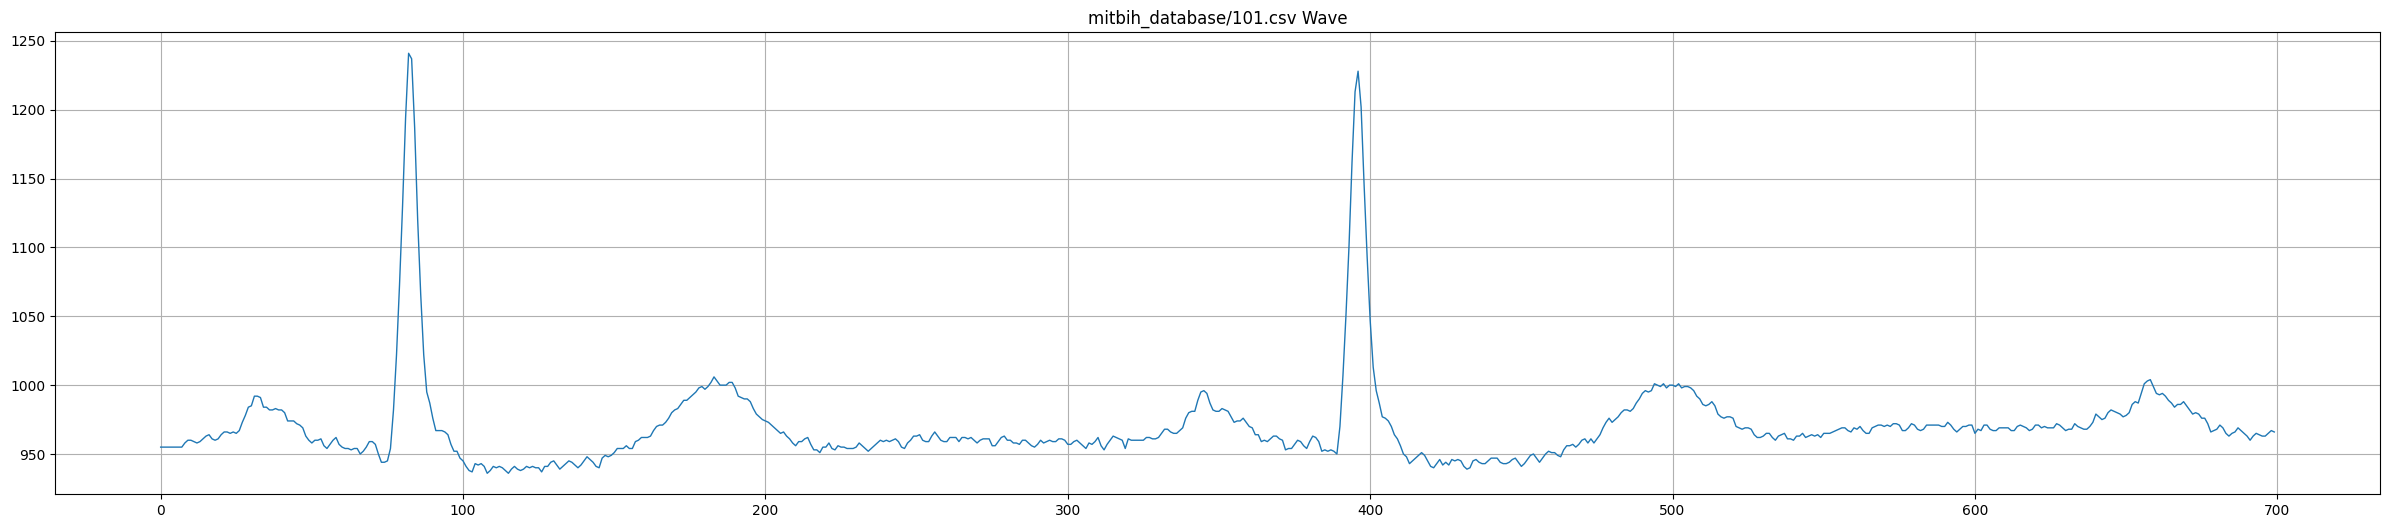

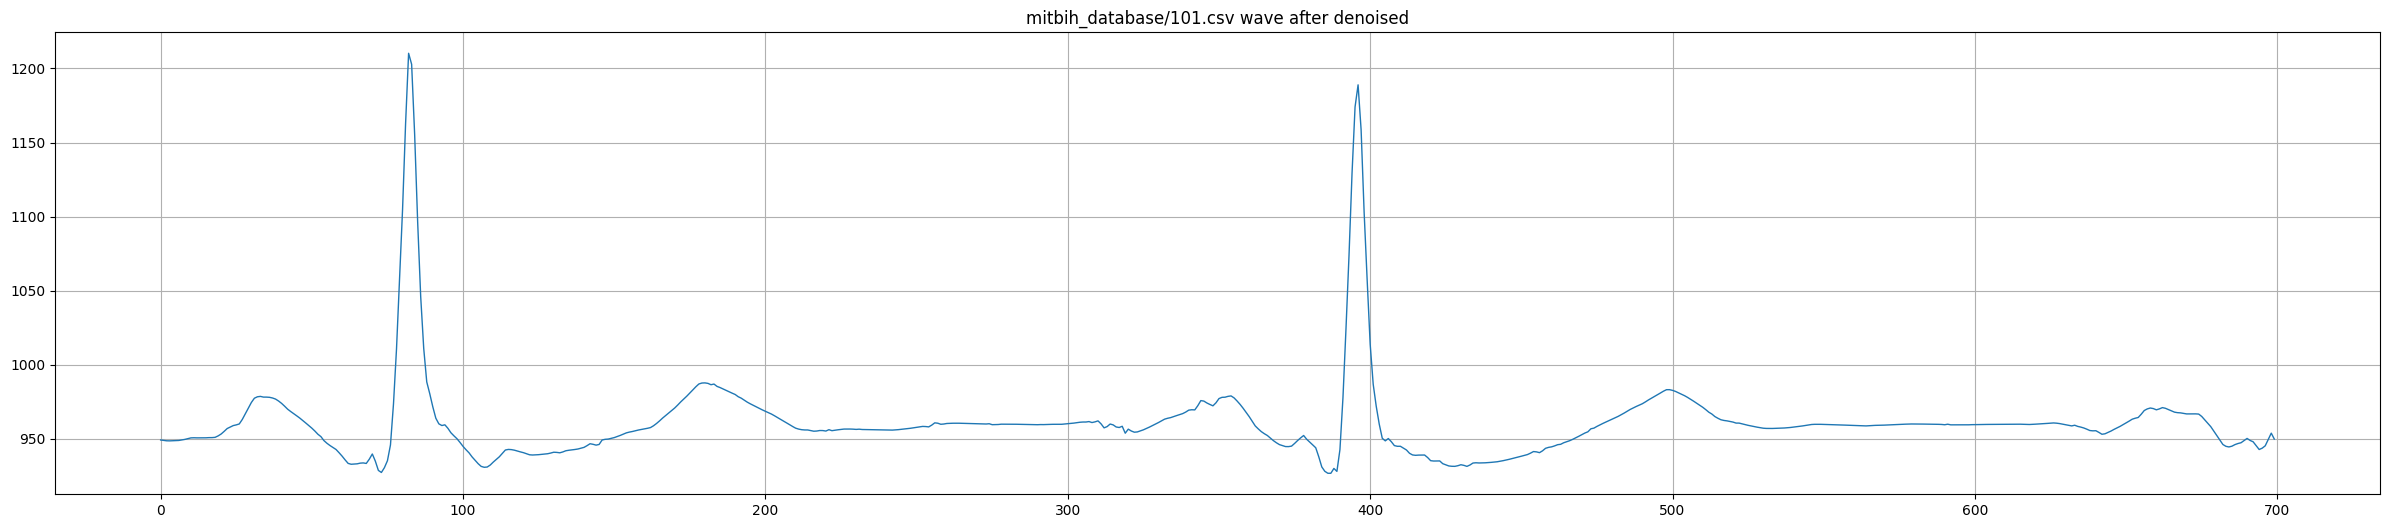

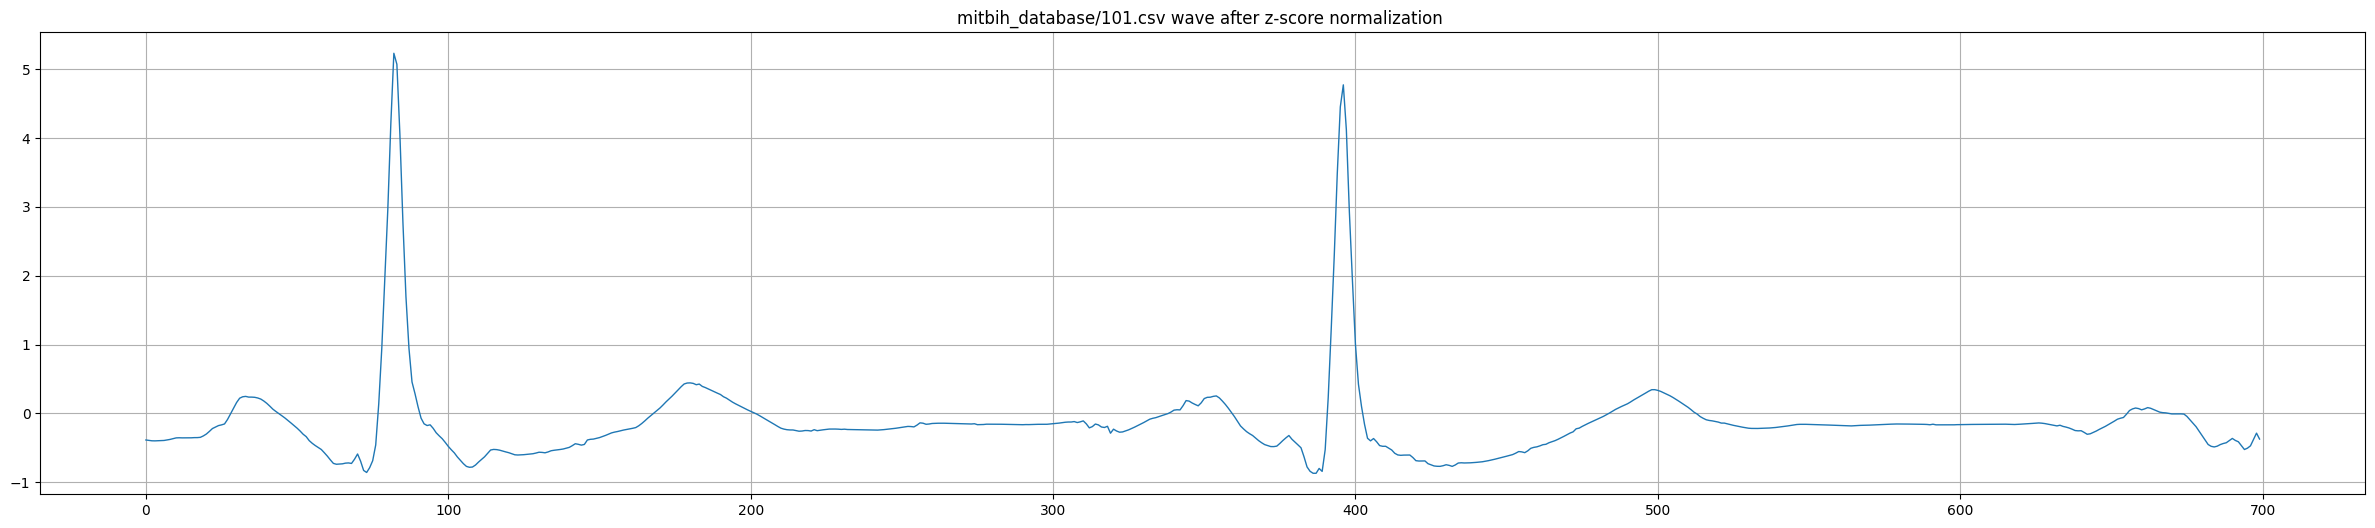

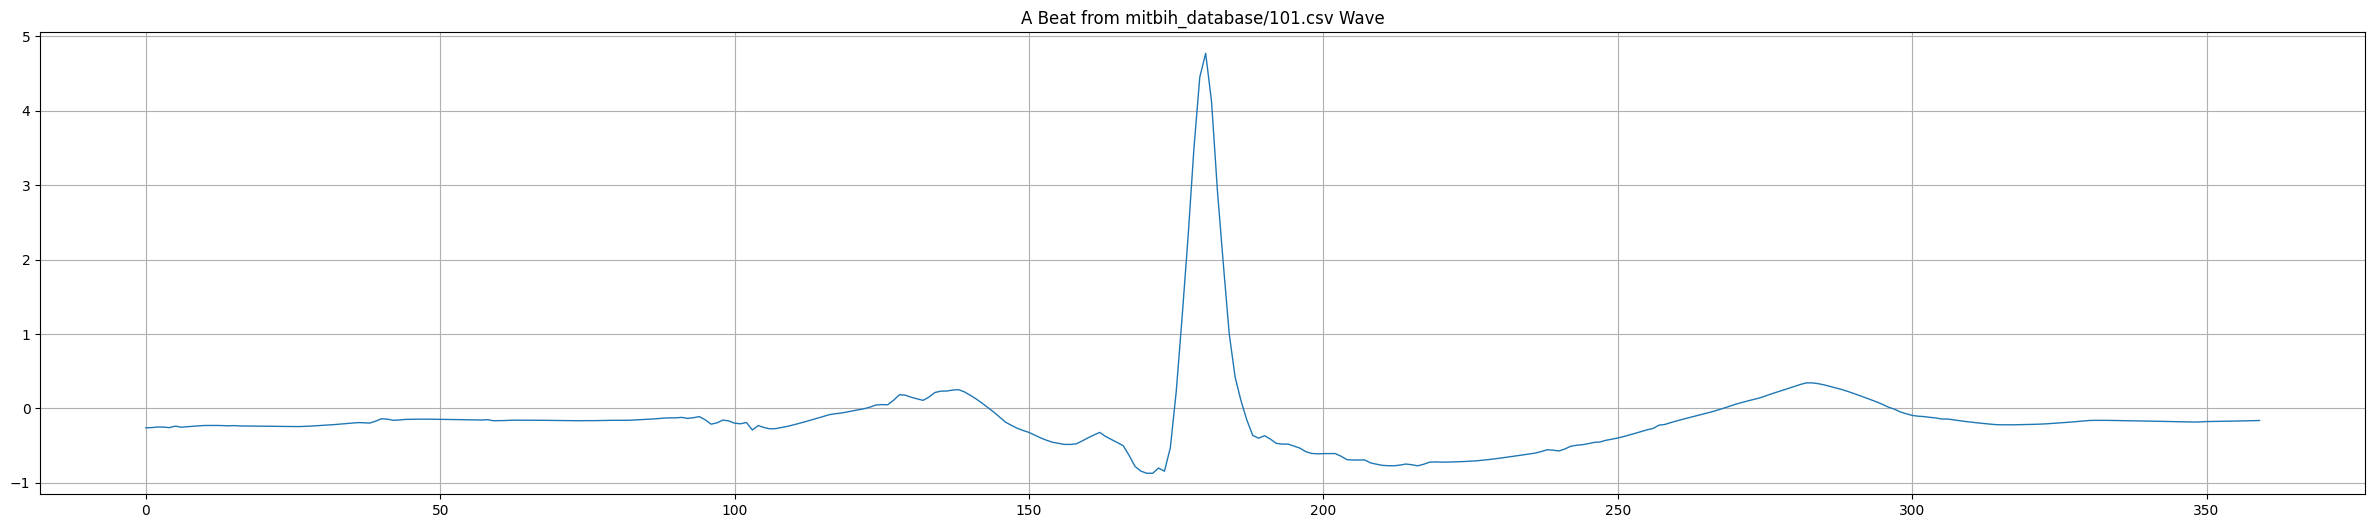

(100012, 360) (100012,)


In [7]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


# Classes Distribution

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


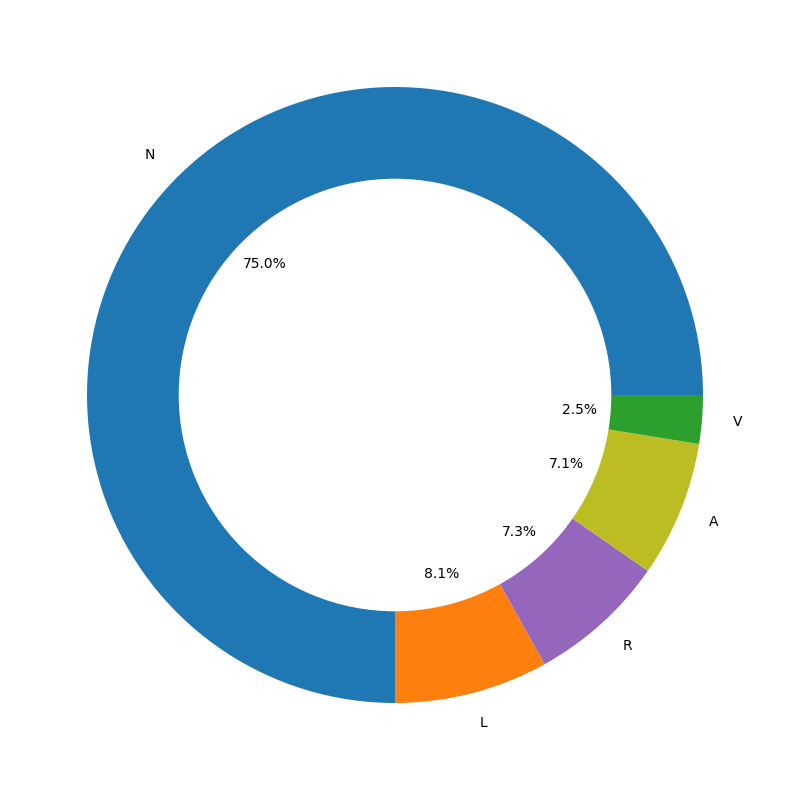

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Rebalancing Classes

In [10]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


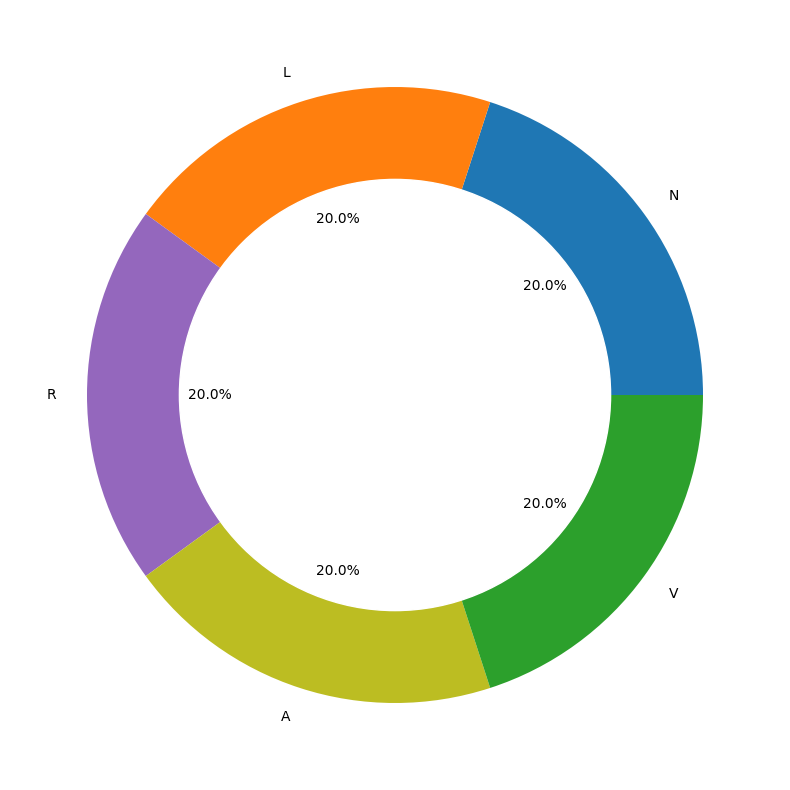

In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [12]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [13]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [14]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


## Building the Model Architecture


In [15]:
im_shape=(360,1)
inputs_cnn=Input(shape=(360,1), name='inputs_cnn')
# convolutional layer 1
conv1_1=Conv1D(64, (6), activation='elu', input_shape=(360,1))(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
#pooling layer 1
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
# convolutional layer 2
conv2_1=Conv1D(128, (3), activation='elu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
# convolutional layer 3
conv3_1=Conv1D(128, (3), activation='elu', input_shape=im_shape)(conv2_1)
conv3_1=BatchNormalization()(conv3_1)
#pooling layer 2
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
# convolutional layer 4
conv4_1=Conv1D(256, (3), activation='elu', input_shape=im_shape)(pool2)
conv4_1=BatchNormalization()(conv4_1)
# convolutional layer 5
conv5_1=Conv1D(256, (3), activation='elu', input_shape=im_shape)(conv4_1)
conv5_1=BatchNormalization()(conv5_1)
#pooling layer 3
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv5_1)
# flattened layer 1
flatten=Flatten()(pool3)
# dense layers
dense_end1 = Dense(1024, activation='elu')(flatten)

main_output = Dense(5, activation='softmax', name='main_output')(dense_end1)


model = Model(inputs= inputs_cnn, outputs=main_output)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 360, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 355, 64)           448       
                                                                 
 batch_normalization (BatchN  (None, 355, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 178, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 176, 128)          24704     
                                                                 
 batch_normalization_1 (Batc  (None, 176, 128)         512   

In [17]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath='./checkpoints_heavy/my_checkpoint',
                                                 save_best_only=True,monitor = 'val_accuracy',
                                                 verbose=1)

## Compiling the model

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

## Fitting the model

In [19]:
history = model.fit(train_x, train_y, batch_size=36, epochs=60, verbose=1, validation_data=(test_x, test_y),callbacks=[cp_callback])

Epoch 1/60
556/556 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.9252
Epoch 1: val_accuracy improved from -inf to 0.96140, saving model to ./checkpoints_heavy\my_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 54s 96ms/step - loss: 0.4059 - accuracy: 0.9252 - val_loss: 0.1323 - val_accuracy: 0.9614
Epoch 2/60
556/556 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9650
Epoch 2: val_accuracy did not improve from 0.96140
556/556 [==============================] - 50s 90ms/step - loss: 0.1319 - accuracy: 0.9650 - val_loss: 0.2453 - val_accuracy: 0.9446
Epoch 3/60
556/556 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9696
Epoch 3: val_accuracy did not improve from 0.96140
556/556 [==============================] - 50s 90ms/step - loss: 0.1201 - accuracy: 0.9696 - val_loss: 0.1740 - val_accuracy: 0.9580
Epoch 4/60
556/556 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.9811
Epoch 4: val_accuracy improved from 0.96140 to 0.96760, saving model to ./checkpoints_heavy\my_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 53s 96ms/step - loss: 0.0680 - accuracy: 0.9811 - val_loss: 0.1395 - val_accuracy: 0.9676
Epoch 5/60
556/556 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9821
Epoch 5: val_accuracy did not improve from 0.96760
556/556 [==============================] - 51s 92ms/step - loss: 0.0707 - accuracy: 0.9821 - val_loss: 0.1790 - val_accuracy: 0.9648
Epoch 6/60
556/556 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9758
Epoch 6: val_accuracy improved from 0.96760 to 0.98380, saving model to ./checkpoints_heavy\my_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 54s 96ms/step - loss: 0.1181 - accuracy: 0.9758 - val_loss: 0.0840 - val_accuracy: 0.9838
Epoch 7/60
556/556 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9887
Epoch 7: val_accuracy did not improve from 0.98380
556/556 [==============================] - 50s 90ms/step - loss: 0.0409 - accuracy: 0.9887 - val_loss: 0.1172 - val_accuracy: 0.9788
Epoch 8/60
556/556 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9863
Epoch 8: val_accuracy did not improve from 0.98380
556/556 [==============================] - 50s 90ms/step - loss: 0.0604 - accuracy: 0.9863 - val_loss: 0.1909 - val_accuracy: 0.9554
Epoch 9/60
556/556 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9855
Epoch 9: val_accuracy did not improve from 0.98380
556/556 [==============================] - 50s 90ms/step - loss: 0.0710 - accuracy: 0.9855 - val_loss: 0.1383 - val_accuracy: 0.9784
Epoch 10/60
556/556 [======

INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 53s 95ms/step - loss: 0.0847 - accuracy: 0.9847 - val_loss: 0.0875 - val_accuracy: 0.9846
Epoch 12/60
556/556 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9908
Epoch 12: val_accuracy did not improve from 0.98460
556/556 [==============================] - 51s 91ms/step - loss: 0.0528 - accuracy: 0.9908 - val_loss: 0.1006 - val_accuracy: 0.9834
Epoch 13/60
556/556 [==============================] - ETA: 0s - loss: 0.0426 - accuracy: 0.9907
Epoch 13: val_accuracy did not improve from 0.98460
556/556 [==============================] - 51s 92ms/step - loss: 0.0426 - accuracy: 0.9907 - val_loss: 0.1255 - val_accuracy: 0.9754
Epoch 14/60
556/556 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9927
Epoch 14: val_accuracy did not improve from 0.98460
556/556 [==============================] - 51s 92ms/step - loss: 0.0321 - accuracy: 0.9927 - val_loss: 0.2294 - val_accuracy: 0.9636
Epoch 15/60
556/556 [

INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 53s 96ms/step - loss: 0.0358 - accuracy: 0.9932 - val_loss: 0.1037 - val_accuracy: 0.9858
Epoch 18/60
556/556 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9979
Epoch 18: val_accuracy improved from 0.98580 to 0.98680, saving model to ./checkpoints_heavy\my_checkpoint


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 54s 96ms/step - loss: 0.0088 - accuracy: 0.9979 - val_loss: 0.0852 - val_accuracy: 0.9868
Epoch 19/60
556/556 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9961
Epoch 19: val_accuracy did not improve from 0.98680
556/556 [==============================] - 51s 92ms/step - loss: 0.0203 - accuracy: 0.9961 - val_loss: 0.1557 - val_accuracy: 0.9836
Epoch 20/60
556/556 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9906
Epoch 20: val_accuracy did not improve from 0.98680
556/556 [==============================] - 51s 92ms/step - loss: 0.0609 - accuracy: 0.9906 - val_loss: 0.2063 - val_accuracy: 0.9804
Epoch 21/60
556/556 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9939
Epoch 21: val_accuracy did not improve from 0.98680
556/556 [==============================] - 51s 92ms/step - loss: 0.0421 - accuracy: 0.9939 - val_loss: 0.1772 - val_accuracy: 0.9808
Epoch 22/60
556/556 [

INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 54s 97ms/step - loss: 0.0331 - accuracy: 0.9952 - val_loss: 0.1250 - val_accuracy: 0.9872
Epoch 25/60
556/556 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9964
Epoch 25: val_accuracy did not improve from 0.98720
556/556 [==============================] - 51s 91ms/step - loss: 0.0167 - accuracy: 0.9964 - val_loss: 0.1891 - val_accuracy: 0.9800
Epoch 26/60
556/556 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9966
Epoch 26: val_accuracy did not improve from 0.98720
556/556 [==============================] - 51s 92ms/step - loss: 0.0147 - accuracy: 0.9966 - val_loss: 0.1259 - val_accuracy: 0.9854
Epoch 27/60
556/556 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9960
Epoch 27: val_accuracy did not improve from 0.98720
556/556 [==============================] - 51s 92ms/step - loss: 0.0281 - accuracy: 0.9960 - val_loss: 0.1814 - val_accuracy: 0.9846
Epoch 28/60
556/556 [

INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints_heavy\my_checkpoint\assets


556/556 [==============================] - 54s 97ms/step - loss: 0.0099 - accuracy: 0.9985 - val_loss: 0.0964 - val_accuracy: 0.9914
Epoch 29/60
556/556 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9969
Epoch 29: val_accuracy did not improve from 0.99140
556/556 [==============================] - 51s 91ms/step - loss: 0.0218 - accuracy: 0.9969 - val_loss: 0.2405 - val_accuracy: 0.9774
Epoch 30/60
556/556 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9970
Epoch 30: val_accuracy did not improve from 0.99140
556/556 [==============================] - 51s 92ms/step - loss: 0.0153 - accuracy: 0.9970 - val_loss: 0.2102 - val_accuracy: 0.9818
Epoch 31/60
556/556 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9960
Epoch 31: val_accuracy did not improve from 0.99140
556/556 [==============================] - 51s 92ms/step - loss: 0.0300 - accuracy: 0.9960 - val_loss: 0.1614 - val_accuracy: 0.9864
Epoch 32/60
556/556 [

Epoch 58/60
556/556 [==============================] - ETA: 0s - loss: 7.7130e-06 - accuracy: 1.0000
Epoch 58: val_accuracy did not improve from 0.99140
556/556 [==============================] - 51s 91ms/step - loss: 7.7130e-06 - accuracy: 1.0000 - val_loss: 0.1646 - val_accuracy: 0.9904
Epoch 59/60
556/556 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9993
Epoch 59: val_accuracy did not improve from 0.99140
556/556 [==============================] - 50s 91ms/step - loss: 0.0049 - accuracy: 0.9993 - val_loss: 0.3589 - val_accuracy: 0.9840
Epoch 60/60
556/556 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9962
Epoch 60: val_accuracy did not improve from 0.99140
556/556 [==============================] - 51s 91ms/step - loss: 0.0352 - accuracy: 0.9962 - val_loss: 0.3760 - val_accuracy: 0.9802


**Plotting the loss convergence**

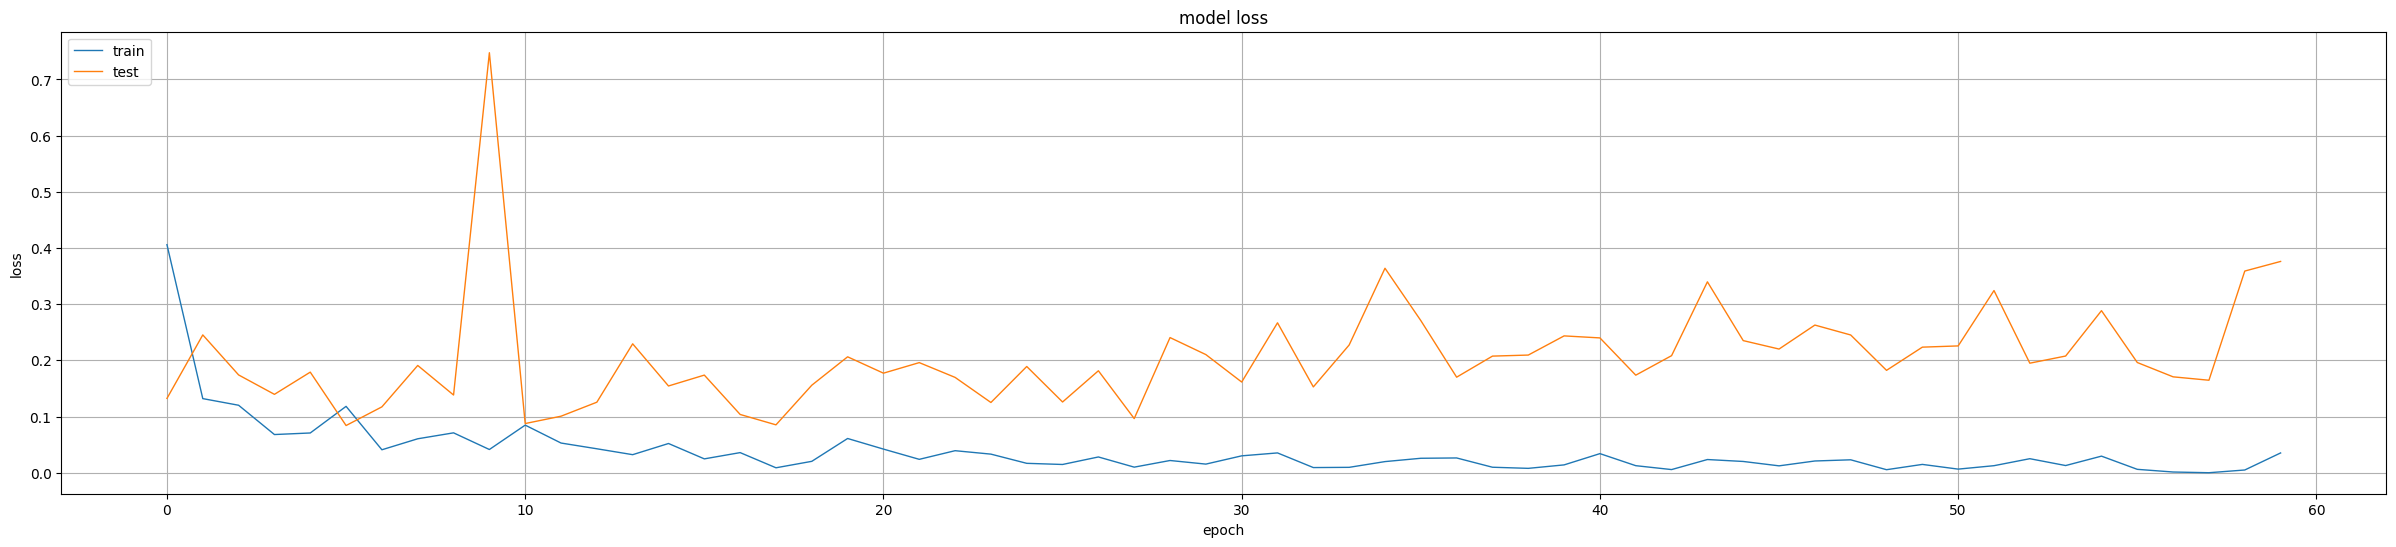

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

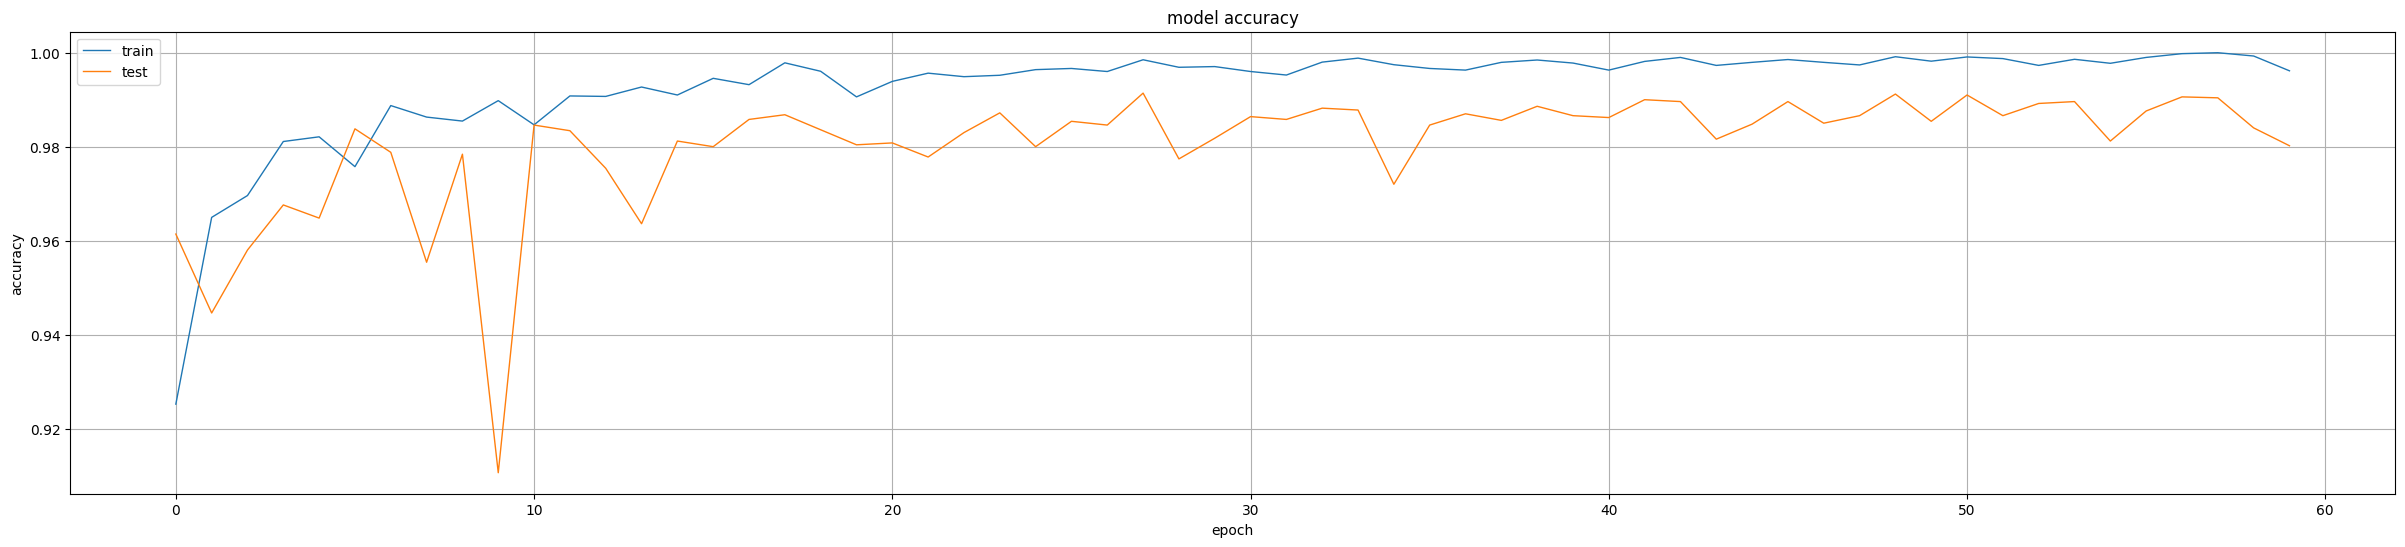

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the loss and accuracy of the model

In [19]:
model.load_weights('./checkpoints_heavy/my_checkpoint')

In [20]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 2s 13ms/step - loss: 0.0139 - accuracy: 0.9978
Test Loss: 0.013882447965443134
Test accuracy: 0.9977999925613403


In [21]:
pred=model.predict(test_x)

157/157 [==============================] - 2s 14ms/step


In [22]:
label_test=[]

for out in test_y:
    label_test.append(np.argmax(out))

In [23]:
label_test_pred=[]

for out in pred:
    label_test_pred.append(np.argmax(out))

In [24]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(label_test)
y_onehot_test = label_binarizer.transform(label_test)
y_onehot_test.shape  # (n_samples, n_classes)

(5000, 5)

In [25]:
label_binarizer.transform([0])

array([[1, 0, 0, 0, 0]])

In [26]:
class_of_interest = 0
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

0

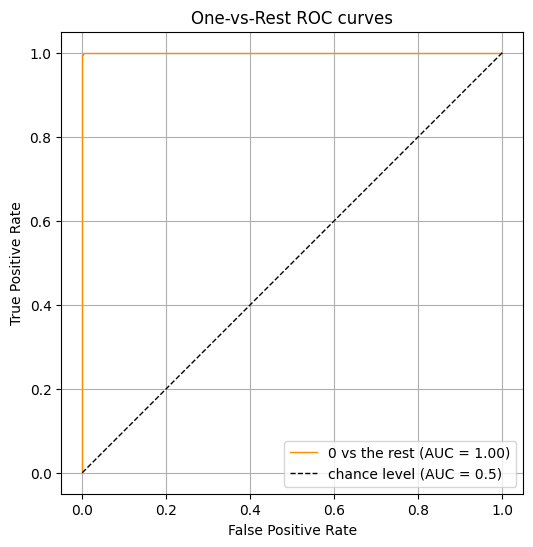

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    pred[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend()
plt.show()

Confusion matrix, without normalization
[[ 978    0    1    4    0]
 [   0  984    0    0    1]
 [   1    0 1024    0    0]
 [   1    0    0 1007    1]
 [   1    0    0    1  996]]


C:\Users\www\anaconda3\envs\ecg\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


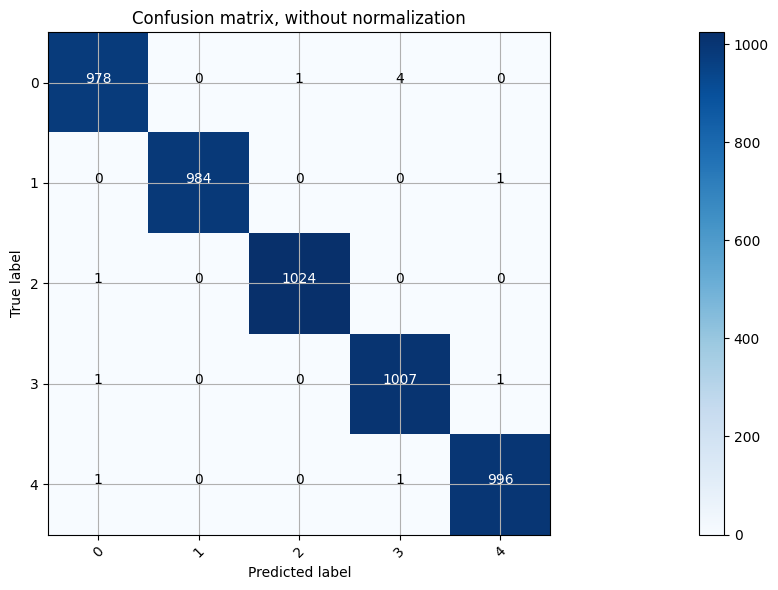

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cnf_matrix = confusion_matrix(label_test, label_test_pred,labels=[0,1,2,3,4])
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list([0,1,2,3,4]),
                      title='Confusion matrix, without normalization')